# Preparando os dados
## Importações e carregamento dos dados

In [71]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualizações
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de ML 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Feature engineering
import optuna
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score, precision_score, matthews_corrcoef, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from sklearn.utils.class_weight import compute_class_weight
from category_encoders import TargetEncoder

# Notebook config
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fast')
palette = ['#0a369d', '#4472ca', '#5e7ce2', '#92b4f4', '#cfdee7']
sns.set_palette(palette)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [9]:
df = pd.read_csv("../data/processed/clean_data.csv")

## Pipeline de pré-processamento

In [10]:
# Primeiro vou transformar a variável target em binário (0, 1)

df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [12]:
features = df.drop(columns = ['Churn'], axis = 1).columns.to_list()
target = 'Churn'

X = df[features]
y = df[target]

In [16]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = 42)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(4225, 19) (1409, 19) (1409, 19)
(4225,) (1409,) (1409,)


In [21]:
cat_features = X_train.select_dtypes(exclude = 'number').columns.to_list()
num_features = X_train.select_dtypes(include = 'number').columns.to_list()

In [23]:
cat_transformer = Pipeline([
    ('cat_imput', CategoricalImputer(imputation_method = 'frequent')),
    ('cat_encoding', TargetEncoder())
])

num_transformer = Pipeline([
    ('num_imput', MeanMedianImputer(imputation_method = 'median'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

In [26]:
# Para lidar com o desbaleaceamento das classes vamos usar os seguintes pesos 

class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

# Modelagem
## Escolha do modelo base

In [63]:
def model_evaluation(models, X_train, y_train, X_val, y_val):
    results = {}

    for name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_val)
        y_proba = pipeline.predict_proba(X_val)[:,1]

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_proba)
        mcc = matthews_corrcoef(y_val, y_pred)

        results[name] = {
            'Accuracy': acc,
            'F1 Score': f1,
            'ROC AUC': roc_auc,
            'MCC': mcc
        }

    return results

In [64]:
models = {
    'Random Forest': RandomForestClassifier(random_state = 42),
    'CatBoost': CatBoostClassifier(verbose = 0, class_weights = weights_dict, random_state = 42),
    'LightGBM': LGBMClassifier(learning_rate=0.05, n_estimators=100, num_leaves=31, is_unbalance = True, random_state = 42),
    'XGBoost': XGBClassifier(objective='binary:logistic', class_weights = weights_dict, random_state = 42)
}

In [65]:
results = model_evaluation(models, X_train, y_train, X_val, y_val)
pd.DataFrame(results).T

[LightGBM] [Info] Number of positive: 1117, number of negative: 3108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264379 -> initscore=-1.023333
[LightGBM] [Info] Start training from score -1.023333


,Accuracy,F1 Score,ROC AUC,MCC
Random Forest,0.790632,0.559043,0.823369,0.431482
CatBoost,0.760114,0.625277,0.834215,0.468178
LightGBM,0.756565,0.625137,0.834854,0.467555
XGBoost,0.795600,0.588571,0.824373,0.456604


O modelo que apresentou os melhores resultados foi o CatBoost. Em uma operadora de telefonia, o custo de um falso negativo é maior que o de um falso positivo. Quando um futuro cancelamento não é identificado, além da perda de receita futura, há o custo de aquisição de um novo cliente. Vamos trabalhar na otimização em torno do F1-Score, que é uma métrica de equilíbrio entre precisão e sensibilidade, além de buscar o melhor limiar de decisão para a detecção de possíveis casos de churn.

## Modelo otimizado 

In [69]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "verbose": 0,
        "class_weights": weights_dict
    }

    model = Pipeline([('preprocessor', preprocessor), ('model', CatBoostClassifier(**params))])
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    f1 = f1_score(y_val, predictions)
    return f1

In [72]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-03-07 15:31:49,662] A new study created in memory with name: no-name-bf5e0dd7-d2e0-41ac-8229-213867d47ff9
[I 2025-03-07 15:31:52,482] Trial 0 finished with value: 0.6248648648648648 and parameters: {'learning_rate': 0.0732252662716973, 'depth': 3, 'subsample': 0.13826944146442163, 'colsample_bylevel': 0.7886157624266981, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.6248648648648648.
[I 2025-03-07 15:32:06,921] Trial 1 finished with value: 0.6354515050167224 and parameters: {'learning_rate': 0.0022616070086511797, 'depth': 10, 'subsample': 0.7707130924543054, 'colsample_bylevel': 0.8428814653812295, 'min_data_in_leaf': 55}. Best is trial 1 with value: 0.6354515050167224.
[I 2025-03-07 15:32:10,415] Trial 2 finished with value: 0.6269592476489029 and parameters: {'learning_rate': 0.004359627766641366, 'depth': 4, 'subsample': 0.7308234714002769, 'colsample_bylevel': 0.23481803509614346, 'min_data_in_leaf': 93}. Best is trial 1 with value: 0.6354515050167224.
[I 2025-03-

In [73]:
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor F1 Score: {study.best_value}")

Melhores hiperparâmetros: {'learning_rate': 0.006232617777096432, 'depth': 9, 'subsample': 0.6803560166453312, 'colsample_bylevel': 0.9966486140633338, 'min_data_in_leaf': 63}
Melhor F1 Score: 0.6426966292134831


In [74]:
best_params = {'learning_rate': 0.006232617777096432, 
               'depth': 9, 
               'subsample': 0.6803560166453312, 
               'colsample_bylevel': 0.9966486140633338, 
               'min_data_in_leaf': 63}

In [76]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(**best_params, verbose = 0, class_weights = weights_dict, random_state = 42))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('cat_encoding',
                                                                   TargetEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num',
                                                  Pipeline(steps=[('num_imput',
                                                                   MeanMedianImputer())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x00000272A1AEE600>)])

In [93]:
y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:,1]

In [101]:
evaluation = {
    'Acurácia': accuracy_score(y_val, y_pred),
    'F1 Score': f1_score(y_val, y_pred),
    'ROC AUC': roc_auc_score(y_val, y_proba),
    'MCC': matthews_corrcoef(y_val, y_pred),
}

print(f"Métricas - Dados de Validação\n{'-' * 30}")
print(pd.Series(evaluation))

Métricas - Dados de Validação
------------------------------
Acurácia    0.770759
F1 Score    0.635851
ROC AUC     0.832760
MCC         0.484518
dtype: float64


Com os melhores hiperparâmetros encontrados podemos seguir para a avaliação do modelo com os dados de teste. 

# Avaliação do modelo
## Métricas e validação cruzada

In [102]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

In [103]:
evaluation = {
    'Acurácia': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba),
    'MCC': matthews_corrcoef(y_test, y_pred),
}

print(f"Métricas - Dados de Teste\n{'-' * 30}")
print(pd.Series(evaluation))

Métricas - Dados de Teste
------------------------------
Acurácia    0.772889
F1 Score    0.642857
ROC AUC     0.860216
MCC         0.497954
dtype: float64


In [104]:
scoring = make_scorer(f1_score)
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_train, y_train, cv = cv, scoring = scoring)
print(f"Média Geral F1 Score: {scores.mean()}")
print(f"Desvio Padrão F1 Score: {scores.std()}")

Média Geral F1 Score: 0.6145068530273494
Desvio Padrão F1 Score: 0.01154780514370792


O modelo apresentou uma boa capacidade de generalização, agora podemos partir para a busca de um melhor limiar de decisão. 

## Melhor limiar de decisão

In [121]:
results = []

for threshold in np.arange(0.05, 1, 0.05):
    predictions = (clf.predict_proba(X_test)[:,1]>threshold)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    results.append((threshold, precision, recall, f1))

In [122]:
results = pd.DataFrame(results, columns = ['threshold', 'precision', 'recall', 'f1'])
results

,threshold,precision,recall,f1
0,0.05,0.337294,0.989276,0.503067
1,0.10,0.370445,0.981233,0.537840
2,0.15,0.397140,0.967828,0.563183
3,0.20,0.419622,0.951743,0.582445
4,0.25,0.442186,0.932976,0.600000
5,0.30,0.459459,0.911528,0.610961
6,0.35,0.479592,0.882038,0.621341
7,0.40,0.507200,0.849866,0.635271
8,0.45,0.528596,0.817694,0.642105
9,0.50,0.550669,0.772118,0.642857


Considerando ainda preservar o F1 Score e seu equilibrio acredito que a melhor escolha seja usar um limiar de 0.40 para detecção de possíveis casos de churn. Temos um ganho considerável na sensibilidade, e assim menos risco de falsos negativos. 

## Visualizações 

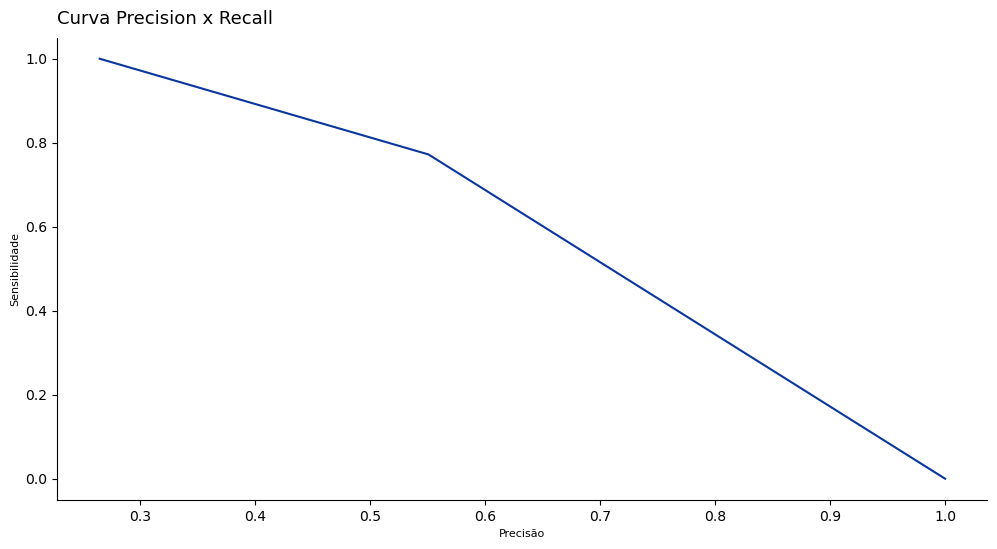

In [128]:
precision, recall, thres = precision_recall_curve(y_test, y_pred)

fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = precision, y = recall)
ax.set_title("Curva Precision x Recall", fontsize = 13, pad = 10, loc = 'left')
ax.set_xlabel("Precisão", fontsize = 8)
ax.set_ylabel("Sensibilidade", fontsize = 8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

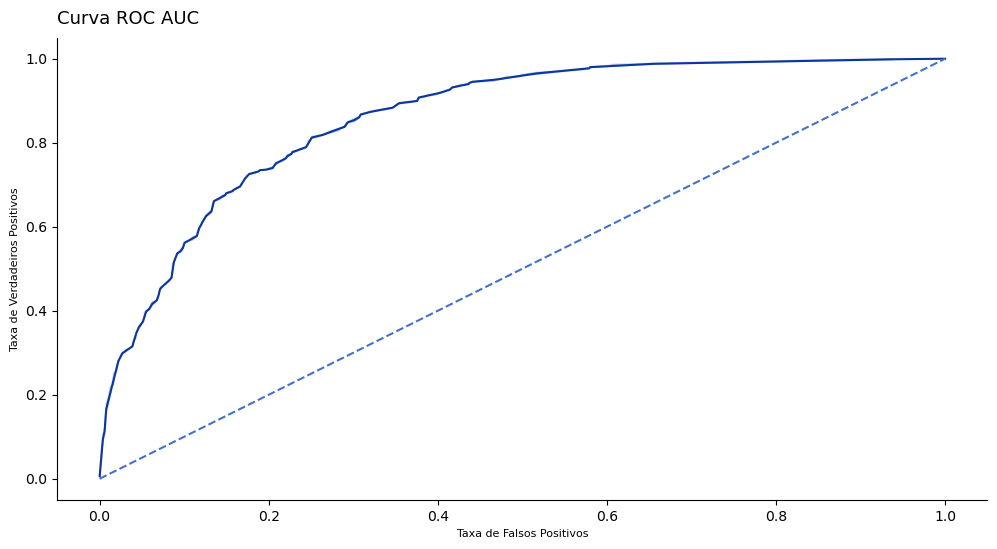

In [136]:
curve = roc_curve(y_test, y_proba)

fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = curve[0], y = curve[1])
plt.plot([0, 1], [0, 1], '--')
ax.set_title("Curva ROC AUC", fontsize = 13, pad = 10, loc = 'left')
ax.set_xlabel("Taxa de Falsos Positivos", fontsize = 8)
ax.set_ylabel("Taxa de Verdadeiros Positivos", fontsize = 8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

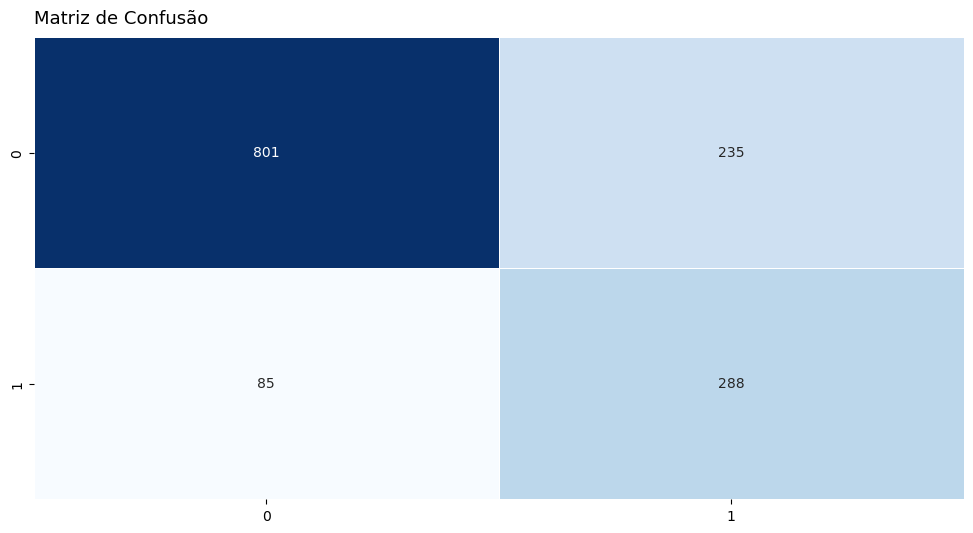

In [137]:
cf = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (12, 6))

sns.heatmap(cf, annot = True, fmt = 'd', linewidths = 0.5, cmap = 'Blues', cbar = False)
ax.set_title("Matriz de Confusão", fontsize = 13, pad= 10, loc = 'left')
plt.show()